# Baeysian 2D model 

In [1]:
import numpy as np 
import pandas as pd 
import emcee 
import matplotlib.pyplot as plt 
from transit import occultnonlin, occultquad
from interpolation import lc_interpolate

### Line Fits
Try out the algorithm by fitting a line

In [ ]:
np.random.seed(123)

# Choose the "true" parameters.
m_true = -0.9594
b_true = 4.294
f_true = 0.534

# Generate some synthetic data from the model.
N = 50
x = np.sort(10 * np.random.rand(N))
yerr = 0.1 + 0.5 * np.random.rand(N)
y = m_true * x + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(0, 10, 500)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [ ]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [ ]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [ ]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

In [ ]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True)

In [ ]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [ ]:
import corner
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);

In [ ]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y")

### 3D Model fit
Here we try out the same exercise from a 3D Model... just something so that we can try out the procedure with less computation time

In [ ]:
#here's the planet model
def new_plar(ph,p,u1,u2,rorb,imp):
    znp = np.sqrt(np.abs(rorb*np.sin(ph*np.pi))**2+imp**2)
    a= occultquad(znp,p,[u1,u2])  
    return(a)

#here's some generated synthetic data
ph = np.linspace(-0.5,0.5,300)
fl = new_plar(ph, 0.11,0.23,0.34,3.12,0.0)
fl = fl*np.random.normal(1,0.0005,300)
fl_err = np.abs(np.random.normal(0,0.0005,300))


plt.errorbar(ph,fl,fl_err,None, marker='.', ls='None')
plt.show()

In [ ]:
# setting up the priors code
def log_prior_pl(theta):
    p, u1, u2, rorb= theta
    if 0 < p < 1 and 0.2 < u1 < 0.3 and 0.3 < u2 < 0.4 and 0 < u1+u2 < 1 and 1 < rorb < 5:
        return 0.0
    return -np.inf

def log_likelihood_pl(theta, ph, fl, fl_err):
    p, u1, u2, rorb = theta
    model = new_plar(ph, p, u1, u2, rorb, 0)
    return -0.5 * np.sum(((fl - model)/fl_err) ** 2)
    #sigma2 = fl_err ** 2 + model ** 2 * np.exp(2 * log_f)
    #return -0.5 * np.sum((fl - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_pl(theta, ph, fl, fl_err):
    lp = log_prior_pl(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_pl(theta, ph, fl, fl_err)

In [ ]:
initial = np.array([0.1,0.2,0.4,3])
nwalkers = 32
ndim = 4
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_pl, args=(ph, fl, fl_err)
)
sampler.run_mcmc(p0, 3000, progress=True)

In [ ]:
tau = sampler.get_autocorr_time()
print(tau)

In [ ]:
import corner
labels = ["p", "u1","u2","rorb","b"]
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[0.11,0.23,0.34,3.12]
);

In [ ]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

print(0.11,0.23,0.34,3.12,0.0)

In [ ]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        a,b,c,d = i
        mod = new_plar(ph,a,b,c,d,0.0)
        models.append(mod)
    spread = 3*np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(5000,flat_samples)

plt.errorbar(ph, fl, fl_err, capsize=0, color='gray', ls='None', zorder=0)
#plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(ph,med_model-spread,med_model+spread,color='red',alpha=0.5,label=r'$3\sigma$ Posterior Spread', zorder=1)
plt.plot(ph, new_plar(ph, 0.11,0.23,0.34,3.12,0.0), "k", label="truth")
#plt.plot(ph, new_plar(ph, 0.099,0.711,0.713,2.89,0.0), "k", label="est")
plt.legend(fontsize=14)
plt.title('True: Rpl:0.11 Rorb:3.12 u1:0.23 u2:0.34 b:0 \n Fit: Rpl:0.107 Rorb:3.07 u1:0.06 u2:0.85 b:0.0')

plt.xlabel("x")
plt.ylabel("y")
#plt.savefig('baeysiantest.png')

### 2D Model Fit
Now we generalize the interpolation routine to include 2D models

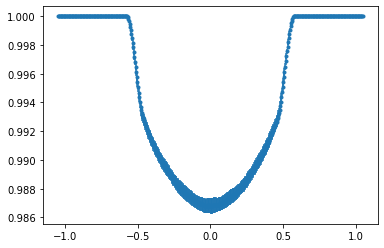

In [2]:
# generate data

#here's some generated synthetic data
df = pd.read_csv('2d3d_0.1R_limb_circ.csv', sep=',')
ph = df['frame']
fl = df['2d']
fl_err = df['2dstd']

plt.errorbar(ph,fl,fl_err,None, marker='.', ls='None')
plt.show()

In [19]:
# setting up the priors code
def log_prior_2d(theta):
    p, rorb, u1, u2= theta
    if 0 < p < 1 and 0 < u1 < 1 and 0 < u2 < 1 and 0 < u1+u2 < 1 and 1 < rorb < 5:
        return 0.0
    return -np.inf

def log_likelihood_2d(theta, ph, fl, fl_err):
    p, rorb, u1, u2 = theta
    model = lc_interpolate(ph, p, rorb, 0.001, u1, u2)
    return -0.5 * np.sum(((fl - model)/fl_err) ** 2)
    #sigma2 = fl_err ** 2 + model ** 2 * np.exp(2 * log_f)
    #return -0.5 * np.sum((fl - model) ** 2 / sigma2 + np.log(sigma2))

def log_probability_2d(theta, ph, fl, fl_err):
    lp = log_prior_2d(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_2d(theta, ph, fl, fl_err)

In [22]:
initial = np.array([0.11,2.11,0.55,0])
nwalkers = 8
ndim = 4
p0 = [np.array(initial) + 1e-5 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability_2d, args=(ph, fl, fl_err)
)
sampler.run_mcmc(p0, 50, progress=True)

  0%|          | 0/50 [00:00<?, ?it/s]/home/ushasi/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ushasi/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  2%|▏         | 1/50 [00:13<11:10, 13.68s/it]/home/ushasi/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
/home/ushasi/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  4%|▍         | 2/50 [00:27<10:50, 13.56s/it]/home/ushasi/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.lo

emcee: Exception while calling your likelihood function:
  params: [1.09989986e-01 2.10997649e+00 5.49978604e-01 1.43460947e-05]
  args: (0     -1.047198
1     -1.043000
2     -1.038803
3     -1.034606
4     -1.030409
         ...   
495    1.030409
496    1.034606
497    1.038803
498    1.043000
499    1.047198
Name: frame, Length: 500, dtype: float64, 0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
495    1.0
496    1.0
497    1.0
498    1.0
499    1.0
Name: 2d, Length: 500, dtype: float64, 0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
495    0.0
496    0.0
497    0.0
498    0.0
499    0.0
Name: 2dstd, Length: 500, dtype: float64)
  kwargs: {}
  exception:


KeyboardInterrupt: 

(720, 4)


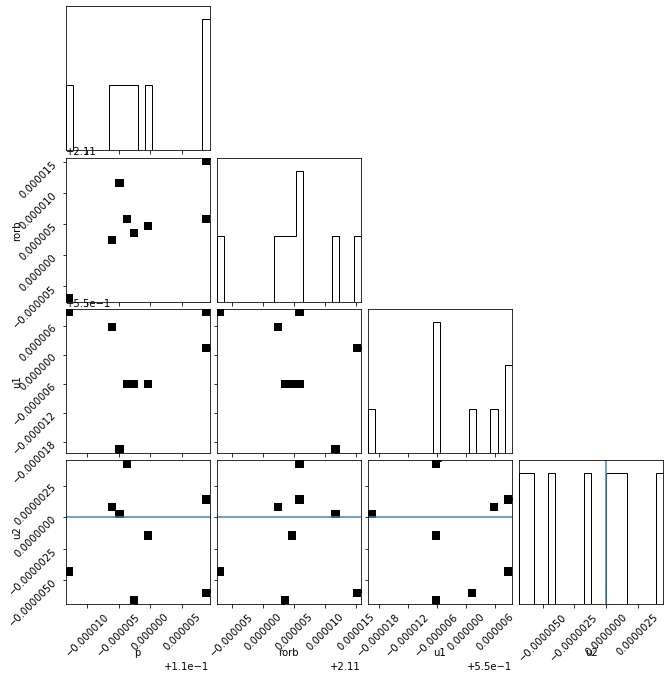

In [16]:
import corner
labels = ["p","rorb", "u1","u2"]
flat_samples = sampler.get_chain(discard=10, thin=1, flat=True)
print(flat_samples.shape)
fig = corner.corner(
    flat_samples, labels=labels, truths=[0.1,2,0.6,0]
)

In [6]:
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

done


IndexError: list index out of range

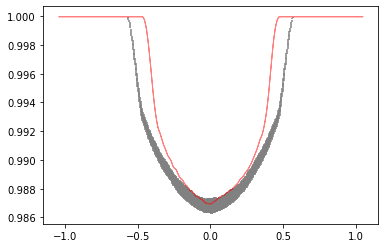

In [8]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas[300:350]:
        a,b,c,d = i
        mod = lc_interpolate(ph,a,b,0.01,c,d)
        models.append(mod)
    spread = 3*np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(5000,flat_samples)
print('done')

plt.errorbar(ph, fl, fl_err, capsize=0, color='gray', ls='None', zorder=0)
#plt.plot(age,new_best_fit_model,label='Highest Likelihood Model')
plt.fill_between(ph,med_model-spread,med_model+spread,color='red',alpha=0.5,label=r'$3\sigma$ Posterior Spread', zorder=1)
plt.plot(ph, lc_interpolate(ph, 0.11,3.12,0.01,0.23,0.34), "k", label="truth")
#plt.plot(ph, new_plar(ph, 0.099,0.711,0.713,2.89,0.0), "k", label="est")
plt.legend(fontsize=14)
plt.title('True: Rpl:0.11 Rorb:3.12 u1:0.23 u2:0.34 b:0 \n Fit: Rpl:0.107 Rorb:3.07 u1:0.06 u2:0.85 b:0.0')

plt.xlabel("x")
plt.ylabel("y")
#plt.savefig('baeysiantest.png')